In [1]:
import sys 
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal

In [2]:
class Particle: ###Particle5
    def __init__(self, init_pose):
        self.pose = init_pose
        
    def motion_update(self, nu, omega, time, noise_rate_pdf): #追加
        ns = noise_rate_pdf.rvs() #順にnn, no, on, oo
        pnu = nu + ns[0]*math.sqrt(abs(nu)/time) + ns[1]*math.sqrt(abs(omega)/time)
        pomega = omega + ns[2]*math.sqrt(abs(nu)/time) + ns[3]*math.sqrt(abs(omega)/time)
        self.pose = IdealRobot.state_transition(pnu, pomega, time, self.pose)

In [3]:
class Mcl: 
    def __init__(self, init_pose, num, motion_noise_stds): 
        self.particles = [Particle(init_pose) for i in range(num)]
        
        v = motion_noise_stds
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)
        
    def motion_update(self, nu, omega, time): ###Mcl5###
        for p in self.particles: p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
        
    def draw(self, ax, elems): 
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2]) for p in self.particles] 
        vys = [math.sin(p.pose[2]) for p in self.particles] 
        elems.append(ax.quiver(xs, ys, vxs, vys, color="blue", alpha=0.5))

In [4]:
class MclAgent(Agent):
    def __init__(self, time_interval, nu, omega, particle_pose, particle_num=100,\
                motion_noise_stds={"nn":0.01, "no":0.02, "on":0.03, "oo":0.04}):
        super().__init__(nu, omega)
        self.mcl = Mcl(particle_pose, particle_num, motion_noise_stds)
        self.time_interval = time_interval
        
    def decision(self, observation=None):        ###MclAgent5
        self.mcl.motion_update(self.nu, self.omega, self.time_interval)
        return self.nu, self.omega
        
    def draw(self, ax, elems):
        self.mcl.draw(ax, elems)

In [5]:
initial_pose = np.array([0, 0, 0]).T   ###mcl5_test（下の出力の先頭数行を記載）
a = MclAgent(0.1, 0.2, 10.0/180*math.pi, initial_pose)
a.mcl.motion_update(0.2, 10.0/180*math.pi, 0.1)
for p in a.mcl.particles:
    print(p.pose)

[ 0.01816963  0.00010194  0.01122105]
[ 0.02300537  0.00026116  0.02270306]
[  1.75731613e-02   9.35562415e-05   1.06475273e-02]
[  2.02408447e-02   9.96933155e-05   9.85062737e-03]
[ 0.01666972  0.00012443  0.014929  ]
[ 0.01938614  0.00020974  0.02163747]
[ 0.01956071  0.00030115  0.03078839]
[ 0.02196529  0.00023885  0.02174734]
[ 0.01445177  0.00013761  0.01904295]
[ 0.02386728  0.00027113  0.0227192 ]
[ 0.02425904  0.00028313  0.02334118]
[ 0.02450155  0.00029034  0.02369844]
[ 0.02122864  0.00020965  0.019751  ]
[ 0.01866553  0.00015298  0.01639087]
[ 0.02129007  0.00019654  0.01846271]
[ 0.02388221  0.00022024  0.01844358]
[ 0.02530736  0.00021639  0.01710016]
[ 0.02185169  0.0002047   0.01873465]
[ 0.0191601   0.00012504  0.01305239]
[ 0.02384299  0.00025916  0.0217384 ]
[ 0.01777367  0.00019375  0.02180065]
[ 0.01686875  0.00016828  0.01995089]
[ 0.01751821  0.00020469  0.02336814]
[ 0.01852897  0.00013884  0.01498622]
[ 0.01941821  0.00023412  0.02411183]
[ 0.02333834  0.0001

<IPython.core.display.Javascript object>


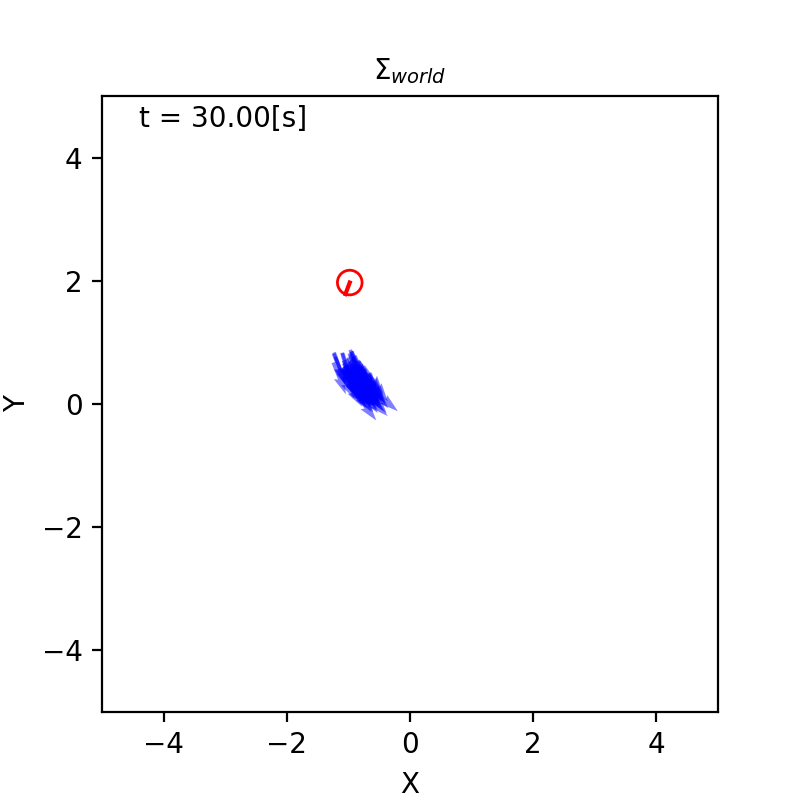

In [6]:
time_interval = 0.1  ###draw_mcl5###
world = World(30, time_interval) 

circling = MclAgent(time_interval, 0.2, 10.0/180*math.pi, np.array([0, 0, 0]).T)
r = Robot( np.array([0, 0, 0]).T, sensor=None, agent=circling, color="red" )
world.append(r)

world.draw()